In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from sklearn import model_selection

### One-hot-encoding for categorical attributes

In [2]:
# Read file and store as pandas dataframe
filename = '../Data/day.csv'
df = pd.read_csv(filename)

for attribute in ['instant','dteday','yr','mnth','holiday','weekday','casual','registered']:
    df = df.drop(attribute, axis=1)
    
# One hot encoding
ohe_df = pd.get_dummies(df, columns = ['season','weathersit'])
ohe_df = ohe_df.drop(['season_4','weathersit_3'], axis=1)    # season_4, weathersit_3 are chosen as reference variables
display(ohe_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0,0.344167,0.363625,0.805833,0.160446,985,1,0,0,0,1
1,0,0.363478,0.353739,0.696087,0.248539,801,1,0,0,0,1
2,1,0.196364,0.189405,0.437273,0.248309,1349,1,0,0,1,0
3,1,0.200000,0.212122,0.590435,0.160296,1562,1,0,0,1,0
4,1,0.226957,0.229270,0.436957,0.186900,1600,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
726,1,0.254167,0.226642,0.652917,0.350133,2114,1,0,0,0,1
727,1,0.253333,0.255046,0.590000,0.155471,3095,1,0,0,0,1
728,0,0.253333,0.242400,0.752917,0.124383,1341,1,0,0,0,1
729,0,0.255833,0.231700,0.483333,0.350754,1796,1,0,0,1,0


### Standardize data

In [3]:
N, M = ohe_df.shape
attribute_names = list(ohe_df.columns)

# Get column indexes
temp_col = ohe_df.columns.get_loc("temp")
atemp_col = ohe_df.columns.get_loc("atemp")
hum_col = ohe_df.columns.get_loc("hum")
wspd_col = ohe_df.columns.get_loc("windspeed")
cnt_col = ohe_df.columns.get_loc("cnt")

# Undo the original max-min normalization
data = ohe_df.values
for row in range(0, N):
    data[row, temp_col] = data[row, temp_col]*(39-(-8)) + (-8)
    data[row, atemp_col] = data[row, atemp_col]*(50-(-16)) + (-16)
    data[row, hum_col] = data[row, hum_col]*100
    data[row, wspd_col] = data[row, wspd_col]*67

# Standarize ratio data attributes
for col in range(temp_col, cnt_col+1): # subtract mean column-wise
    mn = data[:, col].mean(0)
    std = np.std(data[:, col])
    data[:, col] = (data[:, col] - np.ones(N)*mn)/std

# Create DataFrame for visualisation
data_df = pd.DataFrame(data, columns=attribute_names)
display(data_df)

,workingday,temp,atemp,hum,windspeed,cnt,season_1,season_2,season_3,weathersit_1,weathersit_2
0,0.0,-0.826662,-0.679946,1.250171,-0.387892,-1.817953,1.0,0.0,0.0,0.0,1.0
1,0.0,-0.721095,-0.740652,0.479113,0.749602,-1.912999,1.0,0.0,0.0,0.0,1.0
2,1.0,-1.634657,-1.749767,-1.339274,0.746632,-1.629925,1.0,0.0,0.0,1.0,0.0
3,1.0,-1.614780,-1.610270,-0.263182,-0.389829,-1.519898,1.0,0.0,0.0,1.0,0.0
4,1.0,-1.467414,-1.504971,-1.341494,-0.046307,-1.500269,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
726,1.0,-1.318665,-1.521108,0.175807,2.061426,-1.234757,1.0,0.0,0.0,0.0,1.0
727,1.0,-1.323224,-1.346690,-0.266238,-0.452131,-0.728012,1.0,0.0,0.0,0.0,1.0
728,0.0,-1.323224,-1.424344,0.878392,-0.853552,-1.634057,1.0,0.0,0.0,0.0,1.0
729,0.0,-1.309558,-1.490049,-1.015664,2.069444,-1.399023,1.0,0.0,0.0,1.0,0.0


### Set 'cnt' as target variable

In [4]:
# Split dataset into features and target vector
cnt_col = attribute_names.index("cnt")
y = data[:,cnt_col]
X = np.delete(data, cnt_col, axis=1)
attribute_names.pop(cnt_col)
N, M = X.shape

# Add offset attribute
X = np.concatenate((np.ones((X.shape[0],1)),X),1)
attribute_names = [u'offset']+attribute_names
M = M+1

print("N: {}, M: {} (including offset)".format(N,M))

N: 731, M: 11 (including offset)


In [5]:
attribute_names

['offset',
 'workingday',
 'temp',
 'atemp',
 'hum',
 'windspeed',
 'season_1',
 'season_2',
 'season_3',
 'weathersit_1',
 'weathersit_2']

### 1. Regularized Linear Regression

In [6]:
# Values of lambda
lambdas = np.power(10.,np.linspace(-5,9,100))

### Cross Validation

In [7]:
# Cross validation
K_outer = 10
cv_outer = model_selection.KFold(K_outer, shuffle=True, random_state=7)

In [8]:
# Initialize variables
w = np.empty((M,K_outer,len(lambdas)))           
train_error = np.empty((K_outer,len(lambdas)))
test_error = np.empty((K_outer,len(lambdas)))   

mu = np.empty((K_outer, M-1))
sigma = np.empty((K_outer, M-1))


### Training and Testing

In [9]:
for k_out, (train_index, test_index) in enumerate(cv_outer.split(X,y)):
    
    print('\nCross Validation Fold: {0}/{1}'.format(k_out+1,K_outer))
    
    # Split outer fold into parameterisation set and test set
    X_train = X[train_index]
    y_train = y[train_index]
    X_test = X[test_index]
    y_test = y[test_index]
    
    # Standardize inner fold based on training set, and save the mean and std
    mu[k_out, :] = np.mean(X_train[:, 1:], 0)
    sigma[k_out, :] = np.std(X_train[:, 1:], 0)
    X_train[:, 1:] = (X_train[:, 1:] - mu[k_out, :] ) / sigma[k_out, :]

    # Precompute terms
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train
    
    # solve for weights
    for l in range(0,len(lambdas)):
        # Compute parameters for current value of lambda and current CV fold
        lambdaI = lambdas[l] * np.eye(M)
        lambdaI[0,0] = 0 # remove bias regularization
        w[:,k_out,l] = np.linalg.solve(XtX+lambdaI,Xty).squeeze()

        # Evaluate training and validation performance
        train_error[k_out,l] = np.power(y_train-X_train @ w[:,k_out,l].T,2).mean(axis=0)
        test_error[k_out,l] = np.power(y_test-X_test @ w[:,k_out,l].T,2).mean(axis=0)

gen_error = np.mean(test_error,axis=0)     # get mean test_error for each lambda value,
opt_lambda = lambdas[np.argmin(gen_error)]
print("\nOptimal lambda found: ", round(np.log10(opt_lambda),5))


Cross Validation Fold: 1/10

Cross Validation Fold: 2/10

Cross Validation Fold: 3/10

Cross Validation Fold: 4/10

Cross Validation Fold: 5/10

Cross Validation Fold: 6/10

Cross Validation Fold: 7/10

Cross Validation Fold: 8/10

Cross Validation Fold: 9/10

Cross Validation Fold: 10/10

Optimal lambda found:  1.64646


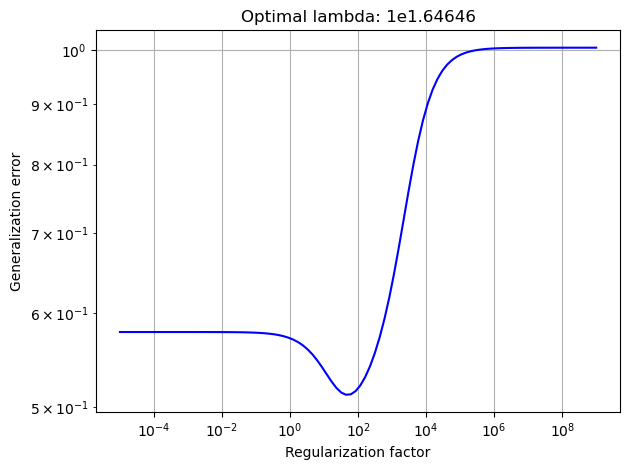

In [10]:
plt.title('Optimal lambda: 1e{0}'.format(round(np.log10(opt_lambda),5)))
plt.loglog(lambdas,gen_error.T,'b-')
plt.xlabel('Regularization factor')
plt.ylabel('Generalization error')
plt.grid()
plt.tight_layout()

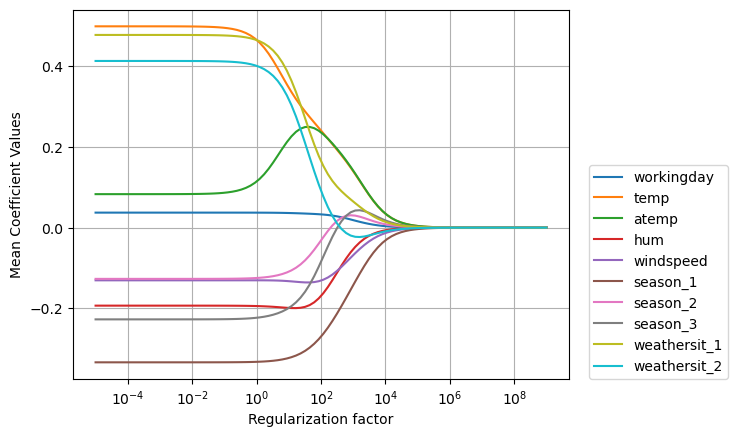

In [11]:
mean_w_vs_lambda = np.squeeze(np.mean(w,axis=1))
plt.semilogx(lambdas,mean_w_vs_lambda.T[:,1:],'-',label=attribute_names[1:]) # Don't plot the bias term
plt.xlabel('Regularization factor')
plt.ylabel('Mean Coefficient Values')
plt.grid()
plt.legend(loc=(1.04, 0))
plt.show()

### Results of Linear Regression

In [12]:
np.argmin(gen_error)
w.shape

(11, 10, 100)

Text(0.5, 1.0, 'Weights from each fold of Regularized Linear Regression of Optimal Lambda')

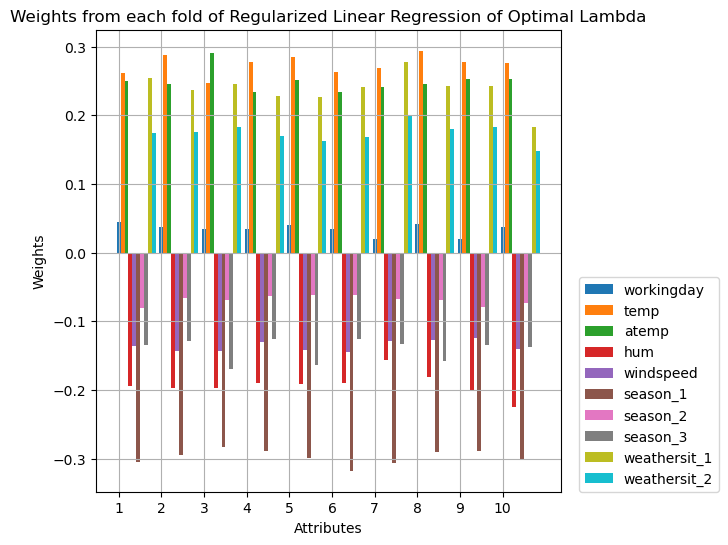

In [13]:
# Bar plot of RLR weights
weights = range(1,M)      # skip offset
bw = 1.0/(len(weights)+1)
r = np.arange(1,K_outer+1)

plt.figure(figsize=(6,6), num=3)
for i in weights:
    plt.bar(r+i*bw, w[i,:,np.argmin(gen_error)], width=bw)
plt.xticks(r+bw, range(1,K_outer+1))
plt.xlabel('Attributes')
plt.ylabel('Weights')
plt.legend(attribute_names[1:M+1], loc=(1.04, 0))
plt.grid()
plt.title('Weights from each fold of Regularized Linear Regression of Optimal Lambda')